Keras auto encoder tutorial based upon https://blog.keras.io/building-autoencoders-in-keras.html but with some modifications.

Topics include:

* Autoencoder basics
* Deep Autoencoders
* Convolutional Autoencoders
* Image Denoising
* Variational Autoencoders (VAE's)

In [1]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda, Conv2D, MaxPooling2D, UpSampling2D
from keras.losses import mse, binary_crossentropy
from keras.models import Model
from keras import backend as K

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline  

Using TensorFlow backend.


# Create a basic autoencoder

In [2]:
# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_2 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


We can extract the encoder model from the first layer of the autoencoder model. Reason we’d want to do this is to get the encoded features (embedding) that in this cvase represent what an encoded image looks like.

In [4]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                25120     
Total params: 25,120
Trainable params: 25,120
Non-trainable params: 0
_________________________________________________________________


As well as the decoder model (we don't use this here though):

In [5]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 784)               25872     
Total params: 25,872
Trainable params: 25,872
Non-trainable params: 0
_________________________________________________________________


Now let's train our autoencoder to reconstruct MNIST digits.

First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer:

In [6]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Let's prepare our input data. We're using MNIST digits, and we're discarding the labels (since we're only interested in encoding/decoding the input images).

In [7]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.

In [8]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


Now let's train our autoencoder for 50 epochs:

In [9]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 33us/step - loss: 0.3611 - val_loss: 0.2710
Epoch 2/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.2638 - val_loss: 0.2525
Epoch 3/50
60000/60000 [==============================] - 1s 10us/step - loss: 0.2413 - val_loss: 0.2278
Epoch 4/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.2199 - val_loss: 0.2099
Epoch 5/50
60000/60000 [==============================] - 1s 10us/step - loss: 0.2052 - val_loss: 0.1979
Epoch 6/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.1946 - val_loss: 0.1885
Epoch 7/50
60000/60000 [==============================] - 1s 10us/step - loss: 0.1863 - val_loss: 0.1811
Epoch 8/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.1796 - val_loss: 0.1750
Epoch 9/50
60000/60000 [==============================] - 1s 1

After 50 epochs, the autoencoder seems to reach a stable train/test loss value of about 0.11. We can try to visualize the reconstructed inputs and the encoded representations. We will use Matplotlib.

Encoded Image Sparsity:  7.600729


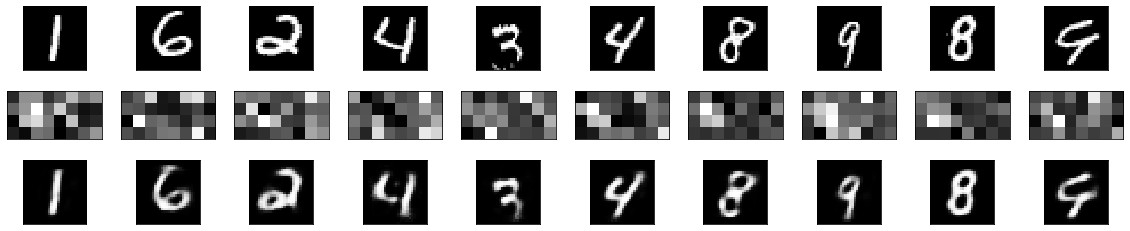

In [10]:
# encode and decode some digits
# note that we take them from the *test* set

def plot_reconstruction(encoder, autoencoder, x_test, embedding_shape = (8,4)):
    #output_imgs = autoencoder.predict(x_test)
    encoded_imgs = encoder.predict(x_test)
    output_imgs = autoencoder.predict(x_test)

    print("Encoded Image Sparsity: ", encoded_imgs.mean())

    num_images  = 10  # how many digits we will display
    np.random.seed(42)
    random_test_images = np.random.randint(x_test.shape[0], size=num_images)    
    
    plt.figure(figsize=(20, 4))
    
    for i, image_idx in enumerate(random_test_images):
        # display original
        ax = plt.subplot(3, num_images, i + 1)
        plt.imshow(x_test[image_idx].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # plot encoded image
        ax = plt.subplot(3, num_images, num_images + i + 1)
        plt.imshow(encoded_imgs[image_idx].reshape(embedding_shape[0], embedding_shape[1]).T)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, num_images, 2 * num_images + i + 1)
        plt.imshow(output_imgs[image_idx].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

plot_reconstruction(encoder, autoencoder, x_test)

Above is what we get. The top row is the original digits, and the bottom row is the reconstructed digits. We are losing quite a bit of detail with this basic approach.

# Adding a sparsity constraint on the encoded representations
In the previous example, the representations were only constrained by the size of the hidden layer (32). In such a situation, what typically happens is that the hidden layer is learning an approximation of PCA (principal component analysis). But another way to constrain the representations to be compact is to add a sparsity contraint on the activity of the hidden representations, so fewer units would "fire" at a given time. In Keras, this can be done by adding an activity_regularizer to our Dense layer:

In [11]:
from keras import regularizers

encoding_dim = 32

input_img = Input(shape=(784,))
# add a Dense layer with a L1 activity regularizer
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_4 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [12]:
encoder = Model(input_img, encoded)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                25120     
Total params: 25,120
Trainable params: 25,120
Non-trainable params: 0
_________________________________________________________________


Let's train this model for 100 epochs (with the added regularization the model is less likely to overfit and can be trained longer). The models ends with a train loss of 0.11 and test loss of 0.10. The difference between the two is mostly due to the regularization term being added to the loss during training (worth about 0.01).

In [13]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s 14us/step - loss: 0.6738 - val_loss: 0.6485
Epoch 2/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.6284 - val_loss: 0.6090
Epoch 3/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.5916 - val_loss: 0.5749
Epoch 4/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.5598 - val_loss: 0.5454
Epoch 5/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.5323 - val_loss: 0.5198
Epoch 6/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.5084 - val_loss: 0.4975
Epoch 7/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.4875 - val_loss: 0.4780
Epoch 8/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.4692 - val_loss: 0.4609
Epoch 9/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.4531 - val_loss: 0.4457
Epoch

Here's a visualization of our new results:

Encoded Image Sparsity:  3.0006825e-06


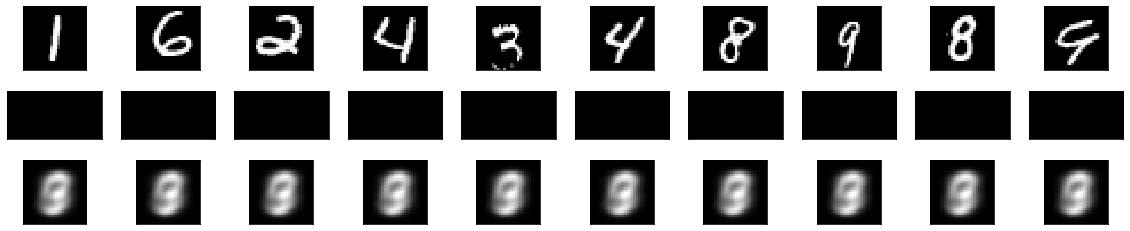

In [14]:
plot_reconstruction(encoder, autoencoder, x_test)

They look pretty similar to the previous model, the only significant difference being the sparsity of the encoded representations. encoded_imgs.mean() yields a value 3.33 (over our 10,000 test images), whereas with the previous model the same quantity was 7.30. So our new model yields encoded representations that are twice sparser.

# Deep autoencoder
We do not have to limit ourselves to a single layer as encoder or decoder, we could instead use a stack of layers, such as:

In [15]:
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu', name='embeddings')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

autoencoder = Model(input_img, decoded)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
embeddings (Dense)           (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_8 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_9 (Dense)              (None, 784)               101136    
Total para

In [16]:
#encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('embeddings').output)
encoder = Model(inputs=autoencoder.input, outputs=encoded)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
embeddings (Dense)           (None, 32)                2080      
Total params: 110,816
Trainable params: 110,816
Non-trainable params: 0
_________________________________________________________________


In [17]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.3356 - val_loss: 0.2635
Epoch 2/100
60000/60000 [==============================] - 1s 15us/step - loss: 0.2590 - val_loss: 0.2555
Epoch 3/100
60000/60000 [==============================] - 1s 15us/step - loss: 0.2479 - val_loss: 0.2389
Epoch 4/100
60000/60000 [==============================] - 1s 14us/step - loss: 0.2282 - val_loss: 0.2180
Epoch 5/100
60000/60000 [==============================] - 1s 14us/step - loss: 0.2132 - val_loss: 0.2083
Epoch 6/100
60000/60000 [==============================] - 1s 14us/step - loss: 0.2046 - val_loss: 0.1976
Epoch 7/100
60000/60000 [==============================] - 1s 15us/step - loss: 0.1930 - val_loss: 0.1906
Epoch 8/100
60000/60000 [==============================] - 1s 15us/step - loss: 0.1861 - val_loss: 0.1820
Epoch 9/100
60000/60000 [==============================] - 1s 15us/step - loss: 0.1801 - val_loss: 0.1

60000/60000 [==============================] - 1s 15us/step - loss: 0.1065 - val_loss: 0.1048
Epoch 78/100
60000/60000 [==============================] - 1s 15us/step - loss: 0.1063 - val_loss: 0.1057
Epoch 79/100
60000/60000 [==============================] - 1s 15us/step - loss: 0.1060 - val_loss: 0.1052
Epoch 80/100
60000/60000 [==============================] - 1s 14us/step - loss: 0.1057 - val_loss: 0.1051
Epoch 81/100
60000/60000 [==============================] - 1s 15us/step - loss: 0.1055 - val_loss: 0.1042
Epoch 82/100
60000/60000 [==============================] - 1s 14us/step - loss: 0.1053 - val_loss: 0.1050
Epoch 83/100
60000/60000 [==============================] - 1s 14us/step - loss: 0.1051 - val_loss: 0.1034
Epoch 84/100
60000/60000 [==============================] - 1s 14us/step - loss: 0.1048 - val_loss: 0.1037
Epoch 85/100
60000/60000 [==============================] - 1s 15us/step - loss: 0.1046 - val_loss: 0.1032
Epoch 86/100
60000/60000 [========================

After 100 epochs, it reaches a train and test loss of ~0.097, a bit better than our previous models. Our reconstructed digits look a bit better too:

Encoded Image Sparsity:  5.035913


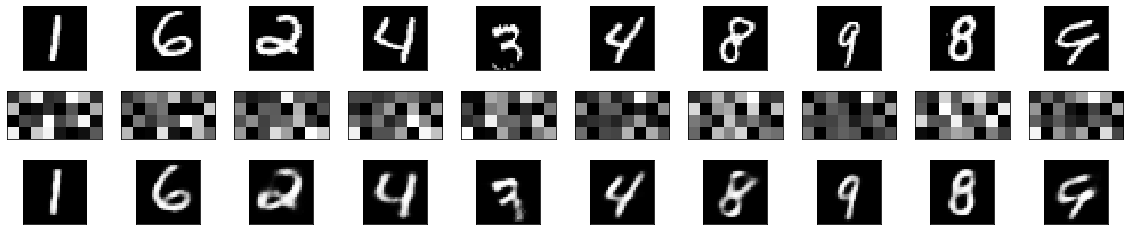

In [18]:
plot_reconstruction(encoder, autoencoder, x_test)

# Convolutional autoencoder
Since our inputs are images, it makes sense to use convolutional neural networks (convnets) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders --they simply perform much better.

Let's implement one. The encoder will consist in a stack of Conv2D and MaxPooling2D layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of Conv2D and UpSampling2D layers.

In [19]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 8)           0         
__________

In [20]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [21]:
encoder = Model(inputs=autoencoder.input, outputs=encoded)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 8)           0         
Total para

To train it, we will use the original MNIST digits with shape (samples, 3, 28, 28), and we will just normalize pixel values between 0 and 1.

In [22]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

Let's train this model for 50 epochs. For the sake of demonstrating how to visualize the results of a model during training, we will be using the TensorFlow backend and the TensorBoard callback.

First, let's open up a terminal and start a TensorBoard server that will read logs stored at /tmp/autoencoder.

tensorboard --logdir=/tmp/autoencoder

Then let's train our model. In the callbacks list we pass an instance of the TensorBoard callback. After every epoch, this callback will write logs to /tmp/autoencoder, which can be read by our TensorBoard server.

In [23]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 73us/step - loss: 0.2074 - val_loss: 0.1643
Epoch 2/50
60000/60000 [==============================] - 2s 37us/step - loss: 0.1563 - val_loss: 0.1462
Epoch 3/50
60000/60000 [==============================] - 2s 37us/step - loss: 0.1433 - val_loss: 0.1374
Epoch 4/50
60000/60000 [==============================] - 2s 37us/step - loss: 0.1356 - val_loss: 0.1329
Epoch 5/50
60000/60000 [==============================] - 2s 37us/step - loss: 0.1301 - val_loss: 0.1289
Epoch 6/50
60000/60000 [==============================] - 2s 37us/step - loss: 0.1260 - val_loss: 0.1210
Epoch 7/50
60000/60000 [==============================] - 2s 37us/step - loss: 0.1232 - val_loss: 0.1245
Epoch 8/50
60000/60000 [==============================] - 2s 37us/step - loss: 0.1208 - val_loss: 0.1167
Epoch 9/50
60000/60000 [==============================] - 2s 37us/step - loss: 0.1193 - val_loss: 0.1158
Epoch

This allows us to monitor training in the TensorBoard web interface (by navighating to http://0.0.0.0:6006):

The model converges to a loss of 0.094, significantly better than our previous models (this is in large part due to the higher entropic capacity of the encoded representation, 128 dimensions vs. 32 previously). Let's take a look at the reconstructed digits:

Encoded Image Sparsity:  0.67726946


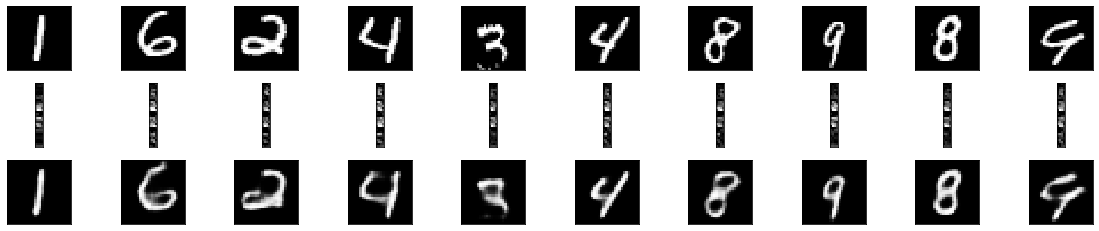

In [24]:
plot_reconstruction(encoder, autoencoder, x_test, embedding_shape=(4, 4 * 8))

We can also have a look at the 128-dimensional encoded representations. These representations are 8x4x4, so we reshape them to 4x32 in order to be able to display them as grayscale images.

# Application to image denoising
Let's put our convolutional autoencoder to work on an image denoising problem. It's simple: we will train the autoencoder to map noisy digits images to clean digits images.

Here's how we will generate synthetic noisy digits: we just apply a gaussian noise matrix and clip the images between 0 and 1.

In [25]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Here's what the noisy digits look like:

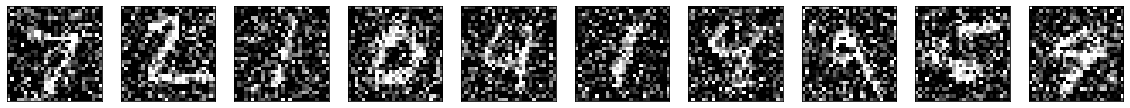

In [26]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

If you squint you can still recognize them, but barely. Can our autoencoder learn to recover the original digits? Let's find out.

Compared to the previous convolutional autoencoder, in order to improve the quality of the reconstructed, we'll use a slightly different model with more filters per layer:

In [27]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 14, 14, 32)        0         
__________

In [28]:
encoder = Model(inputs=autoencoder.input, outputs=encoded)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 32)          0         
Total params: 9,568
Trainable params: 9,568
Non-trainable params: 0
_________________________________________________________________


Let's train it for 100 epochs:

In [29]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 3s 45us/step - loss: 0.1777 - val_loss: 0.1241
Epoch 2/100
60000/60000 [==============================] - 2s 39us/step - loss: 0.1186 - val_loss: 0.1121
Epoch 3/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1113 - val_loss: 0.1089
Epoch 4/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1076 - val_loss: 0.1047
Epoch 5/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1053 - val_loss: 0.1027
Epoch 6/100
60000/60000 [==============================] - 3s 42us/step - loss: 0.1037 - val_loss: 0.1011
Epoch 7/100
60000/60000 [==============================] - 3s 42us/step - loss: 0.1026 - val_loss: 0.1010
Epoch 8/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1018 - val_loss: 0.0997
Epoch 9/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1011 - val_loss: 0.0

60000/60000 [==============================] - 2s 40us/step - loss: 0.0945 - val_loss: 0.0940
Epoch 78/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.0944 - val_loss: 0.0941
Epoch 79/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.0944 - val_loss: 0.0938
Epoch 80/100
60000/60000 [==============================] - 2s 39us/step - loss: 0.0944 - val_loss: 0.0937
Epoch 81/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.0943 - val_loss: 0.0939
Epoch 82/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.0943 - val_loss: 0.0945
Epoch 83/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.0944 - val_loss: 0.0939
Epoch 84/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.0944 - val_loss: 0.0944
Epoch 85/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.0943 - val_loss: 0.0939
Epoch 86/100
60000/60000 [========================

Now let's take a look at the results. Top, the noisy digits fed to the network, and bottom, the digits are reconstructed by the network.

Encoded Image Sparsity:  0.17656411


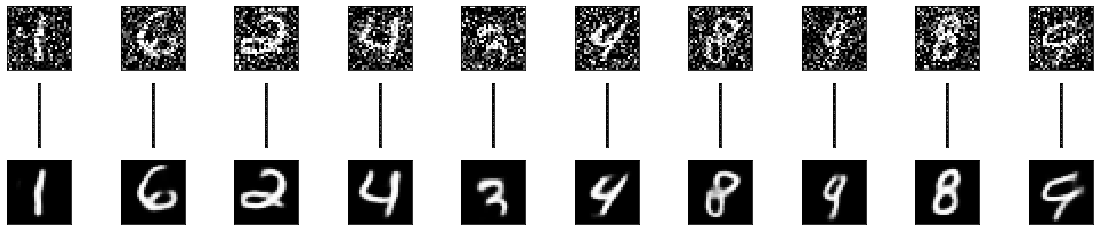

In [30]:
plot_reconstruction(encoder, autoencoder, x_test_noisy, embedding_shape=(7, 7 * 32))

# Sequence-to-sequence autoencoder
If you inputs are sequences, rather than vectors or 2D images, then you may want to use as encoder and decoder a type of model that can capture temporal structure, such as a LSTM. To build a LSTM-based autoencoder, first use a LSTM encoder to turn your input sequences into a single vector that contains information about the entire sequence, then repeat this vector n times (where n is the number of timesteps in the output sequence), and run a LSTM decoder to turn this constant sequence into the target sequence.

We won't be demonstrating that one on any specific dataset. We will just put a code example here for future reference for the reader!

In [31]:
# from keras.layers import Input, LSTM, RepeatVector
# from keras.models import Model
# 
# inputs = Input(shape=(timesteps, input_dim))
# encoded = LSTM(latent_dim)(inputs)
# 
# decoded = RepeatVector(timesteps)(encoded)
# decoded = LSTM(input_dim, return_sequences=True)(decoded)
# 
# sequence_autoencoder = Model(inputs, decoded)
# encoder = Model(inputs, encoded)

# Variational autoencoder (VAE)
Variational autoencoders are a slightly more modern and interesting take on autoencoding.

What is a variational autoencoder, you ask? It's a type of autoencoder with added constraints on the encoded representations being learned. More precisely, it is an autoencoder that learns a latent variable model for its input data. So instead of letting your neural network learn an arbitrary function, you are learning the parameters of a probability distribution modeling your data. If you sample points from this distribution, you can generate new input data samples: a VAE is a "generative model".

How does a variational autoencoder work?

First, an encoder network turns the input samples x into two parameters in a latent space, which we will note z_mean and z_log_sigma. Then, we randomly sample similar points z from the latent normal distribution that is assumed to generate the data, via z = z_mean + exp(z_log_sigma) * epsilon, where epsilon is a random normal tensor. Finally, a decoder network maps these latent space points back to the original input data.

The parameters of the model are trained via two loss functions: a reconstruction loss forcing the decoded samples to match the initial inputs (just like in our previous autoencoders), and the KL divergence between the learned latent distribution and the prior distribution, acting as a regularization term. You could actually get rid of this latter term entirely, although it does help in learning well-formed latent spaces and reducing overfitting to the training data.

The VAE has a modular design. The encoder, decoder and VAE are 3 models that share weights. After training the VAE model,
the encoder can be used to generate latent vectors. The decoder can be used to generate MNIST digits by sampling the
latent vector from a Gaussian distribution with mean = 0 and std = 1.

First load the dataset and setup some parameters

In [32]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

## Encoder Model
First, here's our encoder network, mapping inputs to our latent distribution parameters:

In [33]:
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

We can use these parameters to sample new similar points from the latent space:

In [34]:
# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

In [35]:
# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_10[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_10[0][0]                   
__________________________________________________________________________________________________
z (Lambda)

## Decoder Model
Finally, we can map these sampled latent points back to reconstructed inputs. First we define some layers that can be used for our decoder, autoencoder and later a generator.

In [36]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

In [37]:
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               1536      
_________________________________________________________________
dense_12 (Dense)             (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


## VAE Model
An end-to-end autoencoder mapping inputs to reconstructions

In [38]:
outputs = decoder(encoder(inputs)[2]) # take z from encoder.
vae = Model(inputs, outputs, name='vae_mlp')
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
decoder (Model)              (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________


We train the model using the end-to-end model, with a custom loss function: the sum of a reconstruction term, and the KL divergence regularization term.

In [39]:
reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

vae.compile(optimizer='adam')

We train our VAE on MNIST digits:

In [40]:
vae.fit(x_train, 
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 29us/step - loss: 51.7450 - val_loss: 44.1091
Epoch 2/50
60000/60000 [==============================] - 1s 22us/step - loss: 43.5769 - val_loss: 42.9807
Epoch 3/50
60000/60000 [==============================] - 1s 22us/step - loss: 42.7193 - val_loss: 42.3281
Epoch 4/50
60000/60000 [==============================] - 1s 22us/step - loss: 42.0562 - val_loss: 41.7141
Epoch 5/50
60000/60000 [==============================] - 1s 22us/step - loss: 41.4555 - val_loss: 41.0862
Epoch 6/50
60000/60000 [==============================] - 1s 21us/step - loss: 40.9393 - val_loss: 40.6383
Epoch 7/50
60000/60000 [==============================] - 1s 22us/step - loss: 40.5254 - val_loss: 40.3279
Epoch 8/50
60000/60000 [==============================] - 1s 21us/step - loss: 40.1400 - val_loss: 40.0225
Epoch 9/50
60000/60000 [==============================] - 1s 21us/step - loss: 39.8223 - val_l

Because our latent space is two-dimensional, there are a few cool visualizations that can be done at this point. One is to look at the neighborhoods of different classes on the latent 2D plane:

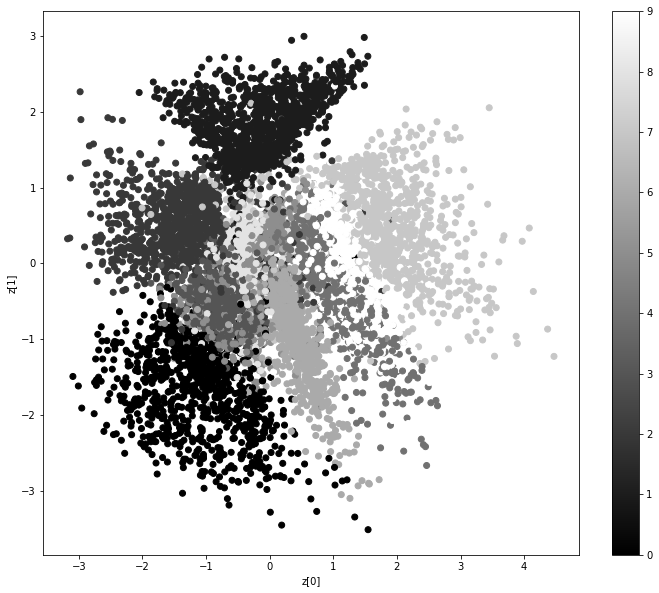

In [41]:
z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size) # here we ignore z_log_var, z as they aren't needed
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

Each of these colored clusters is a type of digit. Close clusters are digits that are structurally similar (i.e. digits that share information in the latent space).

## VAE as Generator

Because the VAE is a generative model, we can also use it to generate new digits! Here we will scan the latent plane, sampling latent points at regular intervals, and generating the corresponding digit for each of these points. This gives us a visualization of the latent manifold that "generates" the MNIST digits.

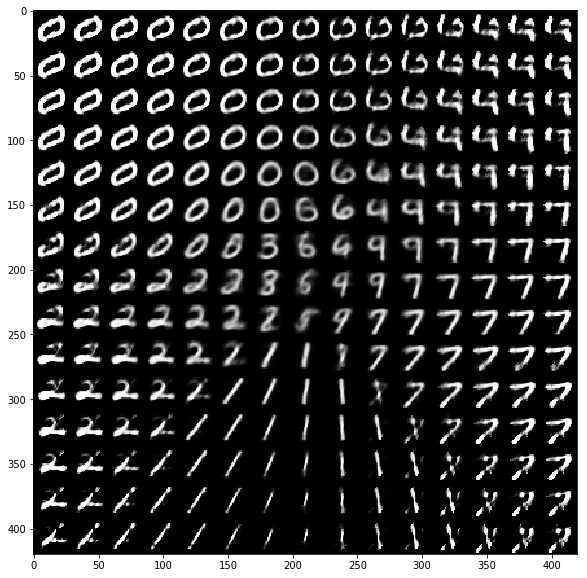

In [42]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-5, 5, n)
grid_y = np.linspace(-5, 5, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) #  * epsilon_std
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()